# Arabic Books Clustering Using K-Means

After Scrapping our data, we will preprocess it (Clean, Normalize and Enrich) in order to apply K-means Clustering Algorithm to Cluster our books into different categories.

## 1) Preprocessing

First, Let's import all the needed modules and load the data.

In [21]:
import pandas as pd
import re
import numpy as np
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.charsets import AR_LETTERS_CHARSET
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.disambig.mle import MLEDisambiguator

In [24]:
#load_the_data
data = pd.read_csv("cluster_test1.csv",header=1)
data.head()

,Column1,Column2,Column3,Column4,Column5,Column6
0,الكاتب,قسم الكتاب,عدد الصفحات,دار النشر,حجم الكتاب,تلخيص الكتاب
1,محمود سالم,روايات بوليسية,44 صفحة,مؤسسة هنداوي,2 ميغابايت,نهض طاخ مبكرا وتنكر مرة أخرى بملابس تاجر الشبا...
2,محمود سالم,روايات بوليسية,50 صفحة,مؤسسة هنداوي,2 ميغابايت,لم يدم تختخ طويلاً في التفكير ؛ وضع القفاز الص...
3,محمود سالم,روايات بوليسية,52 صفحة,مؤسسة هنداوي,2 ميغابايت,هذا الاكتشاف الأثري على وشك اكتشافات أثرية أكث...
4,محمود سالم,روايات بوليسية,56 صفحة,مؤسسة هنداوي,2 ميغابايت,بدأت المغامرة المثيرة في إحدى ليالي سبتمبر في ...


In [26]:
#initializing stop words array
stopwords = []
with open('list.txt', encoding='utf8') as file:
    for line in file:
        stopwords.append(line.strip())


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Column1  91 non-null     object
 1   Column2  91 non-null     object
 2   Column3  91 non-null     object
 3   Column4  91 non-null     object
 4   Column5  91 non-null     object
 5   Column6  91 non-null     object
dtypes: object(6)
memory usage: 4.4+ KB


we preprocess our data using 3 steps: 

### 1) Cleaning our data:

    remove urls
    Mentions
    Emotions
    Symbols
    Diacritical marks
    Shapes
    Unwanted Punctuation (basicly anything that is not an arabic word or a number).

In [28]:
def clean_text(text):
    sentence_ar_dediac = dediac_ar(text) #dediacritization using camel tools
    sentence_ar_dediac = re.sub(r"\S*https?:\S*|@\S+", "", sentence_ar_dediac) #remove URLs and mentions even if they are in paranthesis or brackets
    no_punc = ""
    for char in sentence_ar_dediac:
        if char in (list(AR_LETTERS_CHARSET)+[" "]): #removing any thing that is not an arabic letter
            no_punc = no_punc + char
    return no_punc

### 2) Normalizing our data
    Orthographic Normalization
    Unicode Normalization

In [29]:
def normalize_text(text):
    cleaned_text = normalize_alef_maksura_ar(text)
    cleaned_text = normalize_alef_ar(cleaned_text)
    cleaned_text = normalize_teh_marbuta_ar(cleaned_text)
    cleaned_text = normalize_unicode(cleaned_text)
    
    return cleaned_text

### 3) Stopwords and tokenization

In [30]:
def enrichement(text, stopwords=stopwords):
    tokens = simple_word_tokenize(text)
    tokenized = []
    for token in tokens:
        if token not in stopwords:
            tokenized.append(token)
    mle = MLEDisambiguator.pretrained()      
    disambig = mle.disambiguate(tokenized)
    lemmas = [d.analyses[0].analysis['lex'] for d in disambig]
    return lemmas

In [31]:
def preprocess_text(text, clean_text=clean_text, normalize_text=normalize_text, enrichement=enrichement):
    '''
    Inputs:
    text: string in which it will preprocess.
    
    Outputs:
    cleaned_text: the string after it was processed.
    '''
    
    #let's first start with cleaning 
    cleaned = clean_text(text)
                
    # now, for the normalization part
    normalized = normalize_text(cleaned)
    
    #enrichement
    enriched = enrichement(normalized)
    #return normalized
    return enriched

In [32]:
def preprocess_data(data, preprocess_text=preprocess_text):
    '''
    Inputs:
    data: is the dataframe we want to apply our function on
    
    Outputs:
    data: the dataframe after applying the cleaning and normalization on each cell.
    
    '''
    for row in range(data.shape[0]):
        for column in range(data.shape[1]):
            for_cleaning = str(data.iloc[row][column])
            data.iloc[row][column] = preprocess_text(for_cleaning)
    return data


In [33]:
data=data.drop(data.index[0])
data=preprocess_data(data)
data.head()


,Column1,Column2,Column3,Column4,Column5,Column6
1,"[مَحْمُود, سالِم]","[رِوايَة, بُولِيسِيّ]",[صَفْحَة],"[مُؤَسِّس, هِنْداوِيّ]",[مِيغابايت],"[نَهَض, طاخ, مُبَكِّر, أَنْكَر, مَرَّة, أُخْرَ..."
2,"[مَحْمُود, سالِم]","[رِوايَة, بُولِيسِيّ]",[صَفْحَة],"[مُؤَسِّس, هِنْداوِيّ]",[مِيغابايت],"[دام, تَخْتَخ, طَوِيل, تَفْكِير, وَضْع, قُفّاز..."
3,"[مَحْمُود, سالِم]","[رِوايَة, بُولِيسِيّ]",[صَفْحَة],"[مُؤَسِّس, هِنْداوِيّ]",[مِيغابايت],"[ٱِكْتِشاف, أَثَرِيّ, وَشْك, ٱِكْتِشاف, أَثَر,..."
4,"[مَحْمُود, سالِم]","[رِوايَة, بُولِيسِيّ]",[صَفْحَة],"[مُؤَسِّس, هِنْداوِيّ]",[مِيغابايت],"[بَدَأ, مُغامَرَة, مُثِير, أَحَد, لَيْلَة, ساع..."
5,"[مَحْمُود, سالِم]","[رِوايَة, بُولِيسِيّ]",[صَفْحَة],"[مُؤَسِّس, هِنْداوِيّ]",[مِيغابايت],"[أَمْضَى, تَخْتَخ, بَقِي, مَساء, فَكَّر, لُغْز..."


Now, that we've processed our data and managed to obtain clean tokenized data, it's ready for the next step

## 2) Features Extraction

we will extract features by calculating the TF_IDF matrix manually.

In [34]:
#set of unique words
wordset=[]
for row in range(data.shape[0]):
        for token in data.iloc[row][5]:
            if token not in wordset:
                wordset.append(token)
    

In [35]:
print(len(wordset))

1413


In [36]:
#function returns the dictionary of the dataset
def Dictionary(data,wordset):
    word_dict=dict.fromkeys(wordset, 0)
    for row in range(0,data.shape[0]-1):      
        for token in data.iloc[row][5]:
            word_dict[token] += 1
    return word_dict
print(Dictionary(data,wordset))

{'نَهَض': 1, 'طاخ': 1, 'مُبَكِّر': 1, 'أَنْكَر': 1, 'مَرَّة': 5, 'أُخْرَى': 7, 'مَلْبَس': 1, 'تاجِر': 1, 'شَبابِيّ': 1, 'شَقّ': 1, 'طَرِيق': 9, 'مسرعا': 1, 'مَنْزِل': 5, 'شاوِيش': 3, 'فراك': 1, 'جانِب': 1, 'عَمُود': 1, 'نُور': 3, 'مَع': 14, 'عَرَبَة': 1, 'صَغِير': 7, 'نادَى': 1, 'وَقْت': 1, 'آخَر': 7, 'نِداء': 3, 'عالِي': 1, 'روبابكيارسائل': 1, 'مَجْهُول': 1, 'وَصَل': 4, 'راق': 1, 'دائِم': 1, 'دَعا': 15, 'بَحْث': 7, 'قِصَّة': 6, 'أَخِير': 2, 'ذَهاب': 2, 'وَجَد': 16, 'قَصْر': 2, 'مَعادِي': 2, 'ٱِسْم': 3, 'رِسالَة': 9, 'مَكْتُوب': 1, 'مُدْهِش': 4, 'دَلِيل': 6, 'سِوَى': 13, 'قُصاصَة': 1, 'كَيْفَ': 5, 'مُغامِر': 19, 'خَمْس': 8, 'كَشَف': 5, 'سِرّ': 3, 'أَخْضَر': 2, 'عاش': 9, 'ماذا': 2, 'داخِل': 1, 'مُلَخَّص': 12, 'كِتاب': 136, 'لُغْز': 24, 'دام': 1, 'تَخْتَخ': 14, 'طَوِيل': 3, 'تَفْكِير': 5, 'وَضْع': 7, 'قُفّاز': 2, 'جَيْب': 2, 'هَرَع': 1, 'أَسْفَل': 1, 'دَرَج': 1, 'قَطّ': 1, 'هَرَّب': 2, 'بَيْنَما': 3, 'صالَة': 1, 'طابِق': 1, 'سُفْلِيّ': 1, 'سَمِع': 4, 'صَوْت': 3, 'بُوم': 1, 'ٱِتَّفَق': 1,

In [37]:
#function takes row number and returns tokens in the whole row
def row_tokens(row):
    tokens=[]
    #for column in range(data.shape[1]):
    for token in data.iloc[row][5]:
        tokens.append(token)
    return tokens
print(row_tokens(1))

['دام', 'تَخْتَخ', 'طَوِيل', 'تَفْكِير', 'وَضْع', 'قُفّاز', 'صَغِير', 'جَيْب', 'هَرَع', 'أَسْفَل', 'دَرَج', 'وَجَد', 'قَطّ', 'هَرَّب', 'بَيْنَما', 'صالَة', 'طابِق', 'سُفْلِيّ', 'سَمِع', 'صَوْت', 'بُوم', 'ٱِتَّفَق', 'صَدِيق', 'عَلامَة', 'خَطّ', 'أَدْرَك', 'شَيْء', 'حَدَث', 'خارِج', 'المنزلصدفه', 'قاد', 'مُغامِر', 'خَمْس', 'كَشَف', 'لُغْز', 'جَدِيد', 'تَحَدِّي', 'نَوْع', 'آخَر', 'شاوِيش', 'رُقْعَة', 'تَخْتَخ', 'صَدِيق', 'بَحَث', 'سِرّ', 'سَرِقَة', 'مَنْزِل', 'أُسْتاذ', 'فاخِر', 'ٱِخْتِفاء', 'صاحِب', 'بَدَأ', 'كَشْف', 'شَبَكَة', 'تَجَسُّس', 'كَبِير', 'هَدَّد', 'أَمْن', 'بَلَد', 'نَجَح', 'مُغامِر', 'حَلّ', 'لُغْز', 'مُساعِد', 'مُفَتِّش', 'مار', 'مُلَخَّص', 'كِتاب', 'لُغْز', 'قُفّاز', 'أَحْمَر']


In [38]:
#function make dictionary for a row
def rowDict(row,wordset):
    word_dict=dict.fromkeys(wordset, 0)
    for token in data.iloc[row][5]:
        word_dict[token] += 1
    return word_dict
#function make dictionary array by which each index in the array is the dictionary of row at that index
def row_Dictionary(data,wordset):
    dict=[]
    for row in range(0,data.shape[0]-1):
        dict.append(rowDict(row,wordset))
    return dict
#print(row_Dictionary(data,wordset))

In [39]:
def compute_tf(word_dict, l):
    tf = {}
    sum_nk = len(l)
    for word, count in word_dict.items():
        tf[word] = count/sum_nk
    return tf

In [40]:
import numpy as np
def compute_idf(strings_list):
    import math
    n = len(strings_list)
    idf = dict.fromkeys(strings_list[0].keys(), 0)
    for l in strings_list:
        for word, count in l.items():
            if count > 0:
                idf[word] += 1
    
    for word, v in idf.items():
        if (v!=0):
            idf[word] = np.log(n / float(v))
    return idf

In [41]:
def compute_tf_idf(tf, idf):
    tf_idf = dict.fromkeys(tf.keys(), 0)
    for word, v in tf.items():
        tf_idf[word] = v * idf[word]
    return tf_idf


In [49]:
dictionary=Dictionary(data,wordset) #retrieve the dictionary for the whole file
Tf=[]
Idf=compute_idf(row_Dictionary(data,wordset))
TfIdf=[]
for i in range(0,data.shape[0]-1):
    Tf.append(compute_tf(dictionary,row_tokens(i)))
    TfIdf.append(compute_tf_idf(Tf[i],Idf))
    
print(len(TfIdf), len(TfIdf[0]))
print(type(TfIdf), type(TfIdf[0]))
#TfIdf[0]

89 1413
<class 'list'> <class 'dict'>


{'نَهَض': 0.07013494327706468,
 'طاخ': 0.07013494327706468,
 'مُبَكِّر': 0.07013494327706468,
 'أَنْكَر': 0.07013494327706468,
 'مَرَّة': 0.24237046942283197,
 'أُخْرَى': 0.2781106803865279,
 'مَلْبَس': 0.07013494327706468,
 'تاجِر': 0.07013494327706468,
 'شَبابِيّ': 0.07013494327706468,
 'شَقّ': 0.07013494327706468,
 'طَرِيق': 0.35757087478267874,
 'مسرعا': 0.07013494327706468,
 'مَنْزِل': 0.24237046942283197,
 'شاوِيش': 0.17791355574244663,
 'فراك': 0.07013494327706468,
 'جانِب': 0.07013494327706468,
 'عَمُود': 0.07013494327706468,
 'نُور': 0.17791355574244663,
 'مَع': 0.4045954150255678,
 'عَرَبَة': 0.07013494327706468,
 'صَغِير': 0.2949709109926343,
 'نادَى': 0.07013494327706468,
 'وَقْت': 0.07013494327706468,
 'آخَر': 0.2781106803865279,
 'نِداء': 0.17791355574244663,
 'عالِي': 0.07013494327706468,
 'روبابكيارسائل': 0.07013494327706468,
 'مَجْهُول': 0.07013494327706468,
 'وَصَل': 0.19389637553826558,
 'راق': 0.07013494327706468,
 'دائِم': 0.07013494327706468,
 'دَعا': 0.4173248832

In [50]:
TfIdfVectorizer=pd.DataFrame(TfIdf)
print(TfIdfVectorizer.shape)
TfIdfVectorizer.head()

(89, 1413)


,نَهَض,طاخ,مُبَكِّر,أَنْكَر,مَرَّة,أُخْرَى,مَلْبَس,تاجِر,شَبابِيّ,شَقّ,...,ٱِشْتَهَى,ٱِسْتَدْرَك,فات,عِلْم,نَفَّذ,خَلْف,نَفِد,حال,شاعِر,جاهِلِيّ
0,0.070135,0.070135,0.070135,0.070135,0.242370,0.278111,0.070135,0.070135,0.070135,0.070135,...,0.375699,0.375699,0.375699,0.751399,0.375699,0.375699,0.375699,0.375699,0.070135,0.070135
1,0.063220,0.063220,0.063220,0.063220,0.218475,0.250691,0.063220,0.063220,0.063220,0.063220,...,0.338659,0.338659,0.338659,0.677317,0.338659,0.338659,0.338659,0.338659,0.063220,0.063220
2,0.060657,0.060657,0.060657,0.060657,0.209618,0.240528,0.060657,0.060657,0.060657,0.060657,...,0.324929,0.324929,0.324929,0.649858,0.324929,0.324929,0.324929,0.324929,0.060657,0.060657
3,0.080154,0.080154,0.080154,0.080154,0.276995,0.317841,0.080154,0.080154,0.080154,0.080154,...,0.429371,0.429371,0.429371,0.858741,0.429371,0.429371,0.429371,0.429371,0.080154,0.080154
4,0.069056,0.069056,0.069056,0.069056,0.238642,0.273832,0.069056,0.069056,0.069056,0.069056,...,0.369919,0.369919,0.369919,0.739839,0.369919,0.369919,0.369919,0.369919,0.069056,0.069056


In [68]:
X = TfIdfVectorizer.to_numpy()
X.shape

(89, 1413)

After finishing the Feature Extraction step, we now have a matrix that is ready to be fed to our model.

## 3) Building the model

before building our k-means model we need to figure out which k is the best number which miinimizes the Sum of Squared Errors(SSE), so we use the Elbow-Method.

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


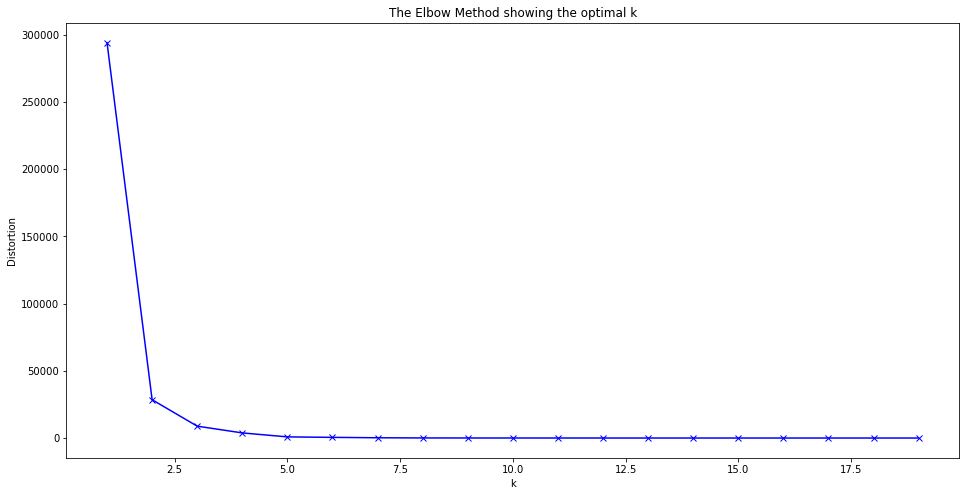

In [69]:
#elbow method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

#inertia here is referring to total sum of squares (or inertia) I of a cluster

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


Using the elbow method we get the best k which is equals to 2.
now let's build our model.

In [70]:
from sklearn.manifold import TSNE
random_state=1
km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=random_state)

y_km = km.fit_predict(X)

In [71]:
y_km #zero means it belongs to the first cluuster, 1 means it belongs to the 2nd cluster.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])